In [148]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -q /content/drive/MyDrive/chest_xray.zip -d /content/


In [3]:
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import os

In [4]:
data_dir="/content/chest_xray"

train_dir=os.path.join(data_dir,"train")
val_dir=os.path.join(data_dir,"val")
test_dir=os.path.join(data_dir,"test")

In [5]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image

In [6]:
class ApplyCLAHE(object):
  def __init__(self,clip_limit=2.0,tile_grid_size=(8,8)):
    self.clip_limit=clip_limit
    self.tile_grid_size=tile_grid_size

  def __call__(self,img):
    img_array=np.array(img)
    clahe = cv2.createCLAHE(
            clipLimit=self.clip_limit,
            tileGridSize=self.tile_grid_size
        )
    if len(img_array.shape)==3:
      lab=cv2.cvtColor(img_array,cv2.COLOR_RGB2LAB)
      l,a,b=cv2.split(lab)
      cl=clahe.apply(l)
      limg=cv2.merge((cl,a,b))
      final_img=cv2.cvtColor(limg,cv2.COLOR_LAB2RGB)
    else:
      final_img=clahe.apply(img_array)

    return Image.fromarray(final_img)


In [40]:
data_transforms={
    "train":transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.CenterCrop(224),
        ApplyCLAHE(clip_limit=2.0),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ]),
    "val_test":transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.CenterCrop(224),
        ApplyCLAHE(clip_limit=2.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
}

In [ ]:
from torchvision import transforms

input_size = 184

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        # ApplyCLAHE(clip_limit=2.0), # Keep your custom CLAHE if defined
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "val_test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        # ApplyCLAHE(clip_limit=2.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
}



In [74]:
image_datasets={
    "train":datasets.ImageFolder(train_dir,data_transforms["train"]),
    "val":datasets.ImageFolder(val_dir,data_transforms["val_test"]),
    "test":datasets.ImageFolder(test_dir,data_transforms["val_test"])
}

In [75]:
batch_size=32

In [76]:
dataloaders={
    "train":DataLoader(image_datasets["train"],batch_size=batch_size,shuffle=True),
    "val":DataLoader(image_datasets["val"],batch_size=batch_size,shuffle=False),
    "test":DataLoader(image_datasets["test"],batch_size=batch_size,shuffle=False)
}
class_names=image_datasets['train'].classes
print(f"Detected Classes: {class_names}")
print(f"Training images: {len(image_datasets['train'])}")

Detected Classes: ['NORMAL', 'PNEUMONIA']
Training images: 5216


In [77]:
dataloaders["train"]

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [81]:
import torch.nn as nn
from torchvision import models

# 1. Load a pre-trained model
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# 2. Freeze the early layers (Optional)
# This keeps the pre-trained weights from changing, which speeds up training
for name, param in model_ft.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# 3. Replace the final Fully Connected layer
# ResNet18's last layer is 'fc'. We change it to output 1 class for Binary Classification.
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(512, 1)
)

model_baseline = model_ft.to(device)

In [82]:
from collections import Counter

train_labels = image_datasets['train'].targets
counts = Counter(train_labels)

neg_count = counts[0]
pos_count = counts[1]

pos_weight_val = neg_count / pos_count
# pos_weight = torch.tensor([pos_weight_val]).to(device)

print(f"Dataset Balance - Normal: {neg_count}, Pneumonia: {pos_count}")
print(f"Applying Positive Weight: {pos_weight_val:.2f}")


Dataset Balance - Normal: 1341, Pneumonia: 3875
Applying Positive Weight: 0.35


In [86]:
from sklearn.metrics import recall_score,f1_score,roc_auc_score
import numpy as np

In [93]:
pos_weight = torch.tensor([1341 / 3875]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Update the optimizer to focus on the deep layers
optimizer = optim.Adam([
    {'params': model_baseline.layer4.parameters(), 'lr': 1e-5},
    {'params': model_baseline.fc.parameters(), 'lr': 1e-4}
], weight_decay=1e-3)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score

def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_recall': [], 'val_recall': [],
        'train_f1': [], 'val_f1': [],
        'train_auc': [], 'val_auc': []
    }

    best_val_loss = float('inf')
    patience = 6
    counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()

            running_loss = 0.0
            all_labels, all_preds, all_probs = [], [], []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    probs = torch.sigmoid(outputs)
                    preds = (probs > 0.5).float()

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.detach().cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            acc = accuracy_score(all_labels, all_preds)
            recall = recall_score(all_labels, all_preds)
            f1 = f1_score(all_labels, all_preds)
            auc = roc_auc_score(all_labels, all_probs)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(acc)
            history[f'{phase}_recall'].append(recall)
            history[f'{phase}_f1'].append(f1)
            history[f'{phase}_auc'].append(auc)

            print(
                f'{phase.upper()} Loss: {epoch_loss:.4f} | '
                f'Acc: {acc:.4f} | Recall: {recall:.4f} | '
                f'F1: {f1:.4f} | AUC: {auc:.4f}'
            )

            if phase == "val":
                scheduler.step(epoch_loss)
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    torch.save(model.state_dict(), 'best_baseline_model.pth')
                    counter = 0
                else:
                    counter += 1
                    if counter >= patience:
                        print("Early stopping triggered!")
                        return history

    return history


In [97]:
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import torch.optim as optim

In [99]:
# START TRAINING
history = train_model(
    model=model_baseline,
    criterion=criterion,
    optimizer=optimizer,
    dataloaders=dataloaders,
    num_epochs=12
)

Epoch 1/12
TRAIN Loss: 0.0967 | Acc: 0.9298 | Recall: 0.9290 | F1: 0.9516 | AUC: 0.9793
VAL Loss: 0.2529 | Acc: 0.7500 | Recall: 0.8750 | F1: 0.7778 | AUC: 0.9062
Epoch 2/12
TRAIN Loss: 0.0781 | Acc: 0.9419 | Recall: 0.9391 | F1: 0.9600 | AUC: 0.9861
VAL Loss: 0.2808 | Acc: 0.7500 | Recall: 0.8750 | F1: 0.7778 | AUC: 0.9062
Epoch 3/12
TRAIN Loss: 0.0702 | Acc: 0.9471 | Recall: 0.9453 | F1: 0.9637 | AUC: 0.9885
VAL Loss: 0.2451 | Acc: 0.8125 | Recall: 0.8750 | F1: 0.8235 | AUC: 0.9062
Epoch 4/12
TRAIN Loss: 0.0665 | Acc: 0.9475 | Recall: 0.9432 | F1: 0.9639 | AUC: 0.9898
VAL Loss: 0.2112 | Acc: 0.7500 | Recall: 0.7500 | F1: 0.7500 | AUC: 0.9219
Epoch 5/12
TRAIN Loss: 0.0589 | Acc: 0.9590 | Recall: 0.9546 | F1: 0.9719 | AUC: 0.9915
VAL Loss: 0.2139 | Acc: 0.8125 | Recall: 0.7500 | F1: 0.8000 | AUC: 0.9219
Epoch 6/12
TRAIN Loss: 0.0570 | Acc: 0.9563 | Recall: 0.9554 | F1: 0.9701 | AUC: 0.9922
VAL Loss: 0.2044 | Acc: 0.8750 | Recall: 0.8750 | F1: 0.8750 | AUC: 0.9531
Epoch 7/12
TRAIN Loss:

In [102]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

Analyzing Training Dataset...
Training Accuracy: 0.9747


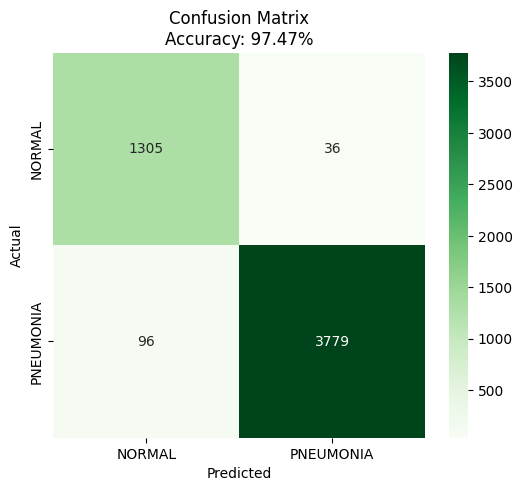

In [ ]:
def plot_training_confusion_matrix(model, loader, class_names=['NORMAL', 'PNEUMONIA']):
    model.eval() 
    y_true = []
    y_pred = []

    print("Analyzing Training Dataset...")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    train_acc = accuracy_score(y_true, y_pred)
    print(f"Training Accuracy: {train_acc:.4f}")

    cm = confusion_matrix(y_true, y_pred)

    # Plotting
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=class_names, yticklabels=class_names)

    plt.title(f'Confusion Matrix\nAccuracy: {train_acc:.2%}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig('train_confusion_matrix.png')
    plt.show()

plot_training_confusion_matrix(model_baseline, dataloaders['train'])

Analyzing Training Dataset...
Training Accuracy: 0.9119


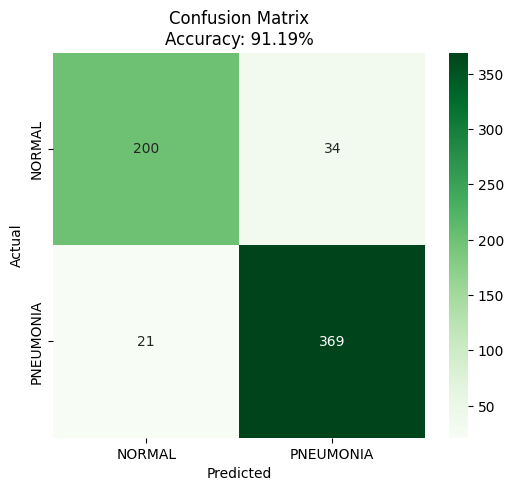

In [105]:
plot_training_confusion_matrix(model_baseline, dataloaders['test'])

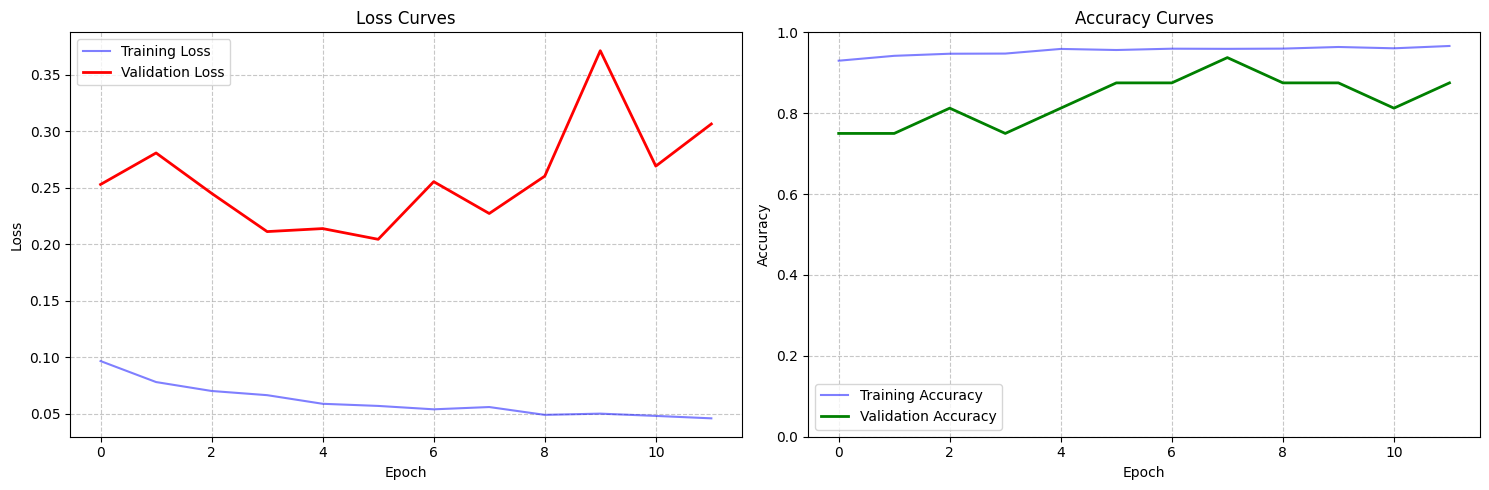

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(15, 5))

    # Left Plot: Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss', color='blue', alpha=0.5)
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='red', linewidth=2)
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Right Plot: Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy', color='blue', alpha=0.5)
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy', color='green', linewidth=2)
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.0]) 
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_results(history)

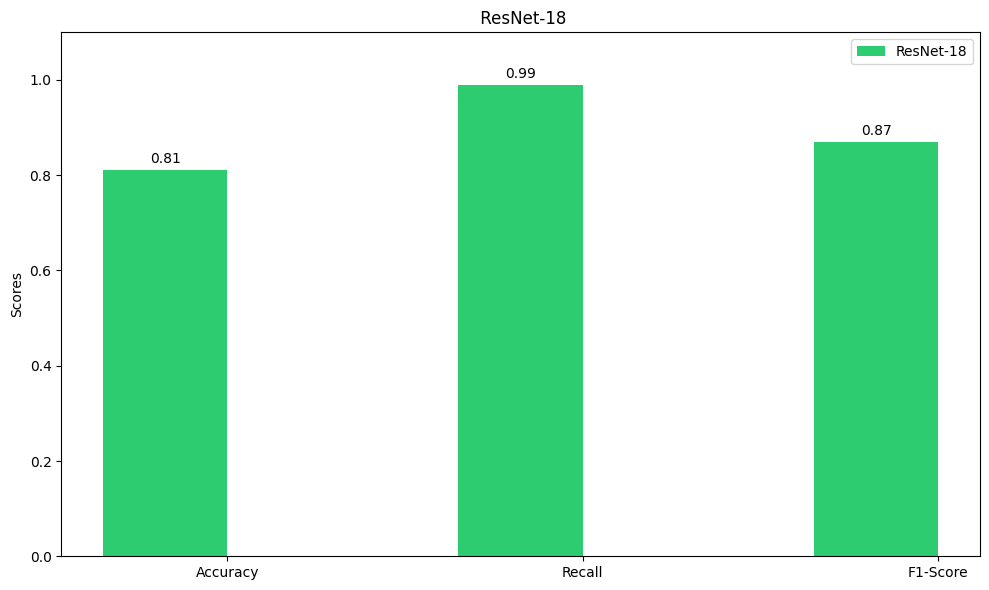

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Recall', 'F1-Score']
resnet_scores = [0.81, 0.99, 0.87] 

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, resnet_scores, width, label='ResNet-18', color='#2ecc71')

ax.set_ylabel('Scores')
ax.set_title(' ResNet-18')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

plt.tight_layout()
plt.show()

In [108]:
# 1. Initialize the data structure
resnet_data = {
    'y_true': [],
    'y_probs': []
}

# 2. Set model to evaluation mode
model_baseline.eval()

# 3. Iterate through the test dataloader
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)

        # Get raw outputs from the model
        outputs = model_baseline(inputs)

        # Convert logits to probabilities using Sigmoid
        probs = torch.sigmoid(outputs)

        # Flatten and store results
        resnet_data['y_true'].extend(labels.cpu().numpy())
        resnet_data['y_probs'].extend(probs.cpu().numpy().flatten())

print("Evaluation complete. 'resnet_data' is ready for plotting.")

Evaluation complete. 'resnet_data' is ready for plotting.


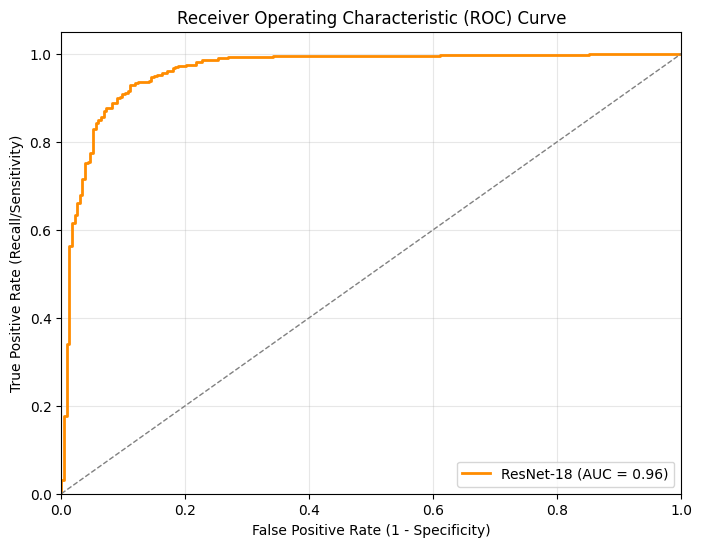

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(resnet_results):
    plt.figure(figsize=(8, 6))

    # ResNet-18 ROC
    fpr_res, tpr_res, _ = roc_curve(resnet_results['y_true'], resnet_results['y_probs'])
    roc_auc_res = auc(fpr_res, tpr_res)
    plt.plot(fpr_res, tpr_res, color='darkorange', lw=2,
             label=f'ResNet-18 (AUC = {roc_auc_res:.2f})')

  

    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Recall/Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

plot_roc_curves(resnet_data)

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_image):
        output = self.model(input_image)

        
        self.model.zero_grad()

        output.backward()

        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()

        cam = F.relu(cam)

        # Normalize between 0 and 1
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.detach().cpu().numpy()

def show_gradcam(img_tensor, model, target_layer, original_image=None):
    """
    Visualizes Grad-CAM on a specific image tensor.
    """
    model.eval()
    grad_cam = GradCAM(model, target_layer)

    heatmap = grad_cam.generate_heatmap(img_tensor.to(device))

    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    if original_image is None:
        img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
    else:
        img = original_image

    superimposed_img = heatmap * 0.4 + (img * 255)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

In [ ]:
for module in model_baseline.modules():
    module._backward_hooks = {}
    module._forward_hooks = {}
    module._is_full_backward_hook = None
print("Hooks cleared! You can now run the Grad-CAM code.")

Hooks cleared! You can now run the Grad-CAM code.


True Label: NORMAL

Output score: -4.4302
Gradients shape: torch.Size([1, 512, 6, 6])
Gradients mean: -0.000138
Gradients std: 0.000901
Gradients min/max: -0.003129 / 0.002820
CAM before ReLU - min/max: -0.328087 / -0.043764
CAM after ReLU - min/max: 0.000000 / 0.000000

Heatmap stats:
Heatmap min/max: 0.000000 / 0.000000
Heatmap mean: 0.000000
Heatmap unique values: 1


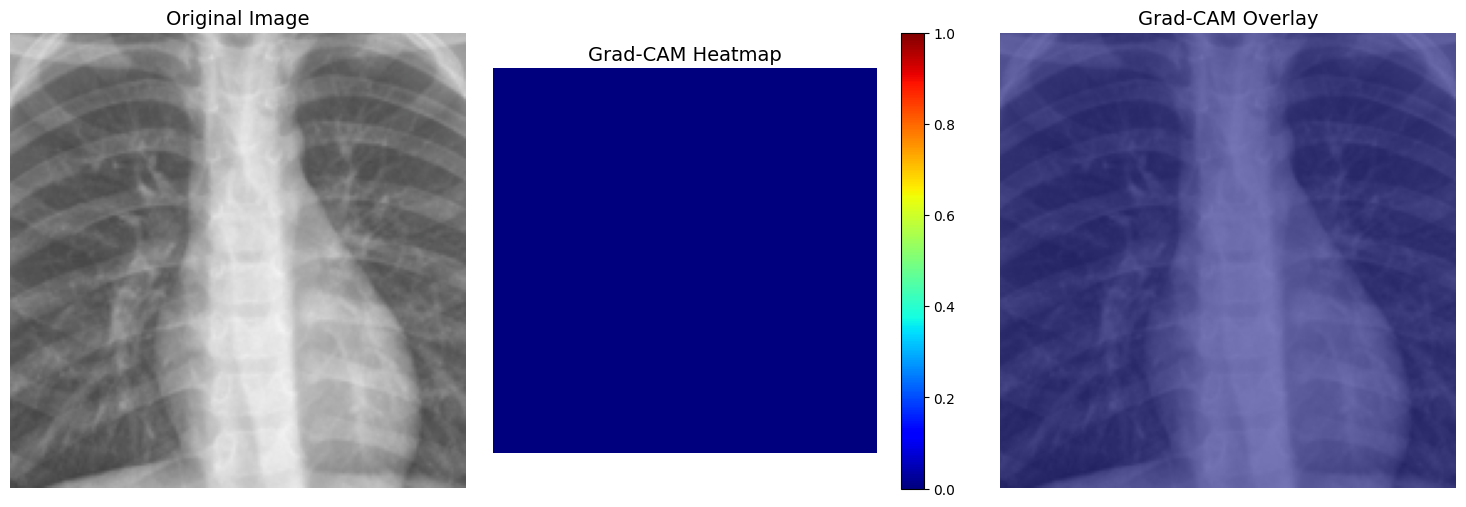


Model prediction: 0.0118 (NORMAL)


In [145]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt


class GradCAM:
    def __init__(self, model):
        self.model = model
        self.activations = None
        self.gradients = None

    def generate_heatmap(self, input_image, use_guided=False):
        self.model.eval()
        input_image = input_image.requires_grad_(True)

        # Manual forward pass to capture layer4 output
        x = self.model.conv1(input_image)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        # Save activations from layer4 and retain gradient
        x.retain_grad()
        self.activations = x

        # Continue with the rest of the network
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        output = self.model.fc(x)

        # Zero gradients
        self.model.zero_grad()

        # Backward pass - use the raw output score
        # For binary classification, we want gradient w.r.t. the logit
        score = output[0, 0]  # Get the single output value
        score.backward()

        # Get gradients from the activations
        self.gradients = self.activations.grad

        # Debug info
        print(f"Output score: {score.item():.4f}")
        print(f"Gradients shape: {self.gradients.shape}")
        print(f"Gradients mean: {self.gradients.mean().item():.6f}")
        print(f"Gradients std: {self.gradients.std().item():.6f}")
        print(f"Gradients min/max: {self.gradients.min().item():.6f} / {self.gradients.max().item():.6f}")

        # Compute channel-wise weights using global average pooling
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Compute weighted combination of activation maps
        cam = torch.sum(weights * self.activations, dim=1).squeeze()

        print(f"CAM before ReLU - min/max: {cam.min().item():.6f} / {cam.max().item():.6f}")

        # Apply ReLU to focus on positive contributions
        cam = F.relu(cam)

        print(f"CAM after ReLU - min/max: {cam.min().item():.6f} / {cam.max().item():.6f}")

        # Normalize between 0 and 1
        if cam.max() > cam.min():
            cam = (cam - cam.min()) / (cam.max() - cam.min())
        else:
            print("WARNING: CAM has no variation! All values are the same.")

        return cam.detach().cpu().numpy()


def show_gradcam(img_tensor, model, device="cpu"):
    model.eval()
    grad_cam = GradCAM(model)

    # Generate heatmap
    heatmap = grad_cam.generate_heatmap(img_tensor.to(device))

    print(f"\nHeatmap stats:")
    print(f"Heatmap min/max: {heatmap.min():.6f} / {heatmap.max():.6f}")
    print(f"Heatmap mean: {heatmap.mean():.6f}")
    print(f"Heatmap unique values: {len(np.unique(heatmap))}")

    # Denormalize image tensor
    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # Get actual image dimensions
    img_height, img_width = img.shape[:2]

    # Resize heatmap to match the actual image size
    heatmap_resized = cv2.resize(heatmap, (img_width, img_height))

    # Apply colormap - convert to 0-255 range
    heatmap_colored = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = heatmap_colored.astype(np.float32) / 255.0

    # Overlay heatmap on image with better blending
    superimposed_img = heatmap_colored * 0.5 + img * 0.5
    superimposed_img = np.clip(superimposed_img, 0, 1)

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Original Image", fontsize=14)
    axes[0].axis("off")

    axes[1].imshow(heatmap_resized, cmap='jet', vmin=0, vmax=1)
    axes[1].set_title("Grad-CAM Heatmap", fontsize=14)
    axes[1].axis("off")
    plt.colorbar(axes[1].imshow(heatmap_resized, cmap='jet', vmin=0, vmax=1), ax=axes[1])

    axes[2].imshow(superimposed_img)
    axes[2].set_title("Grad-CAM Overlay", fontsize=14)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    # Print prediction info
    with torch.no_grad():
        output = model(img_tensor.to(device))
        prediction = torch.sigmoid(output).item()
        print(f"\nModel prediction: {prediction:.4f} ({'PNEUMONIA' if prediction > 0.5 else 'NORMAL'})")


# Get a batch of images from the test set
dataiter = iter(dataloaders['test'])
images, labels = next(dataiter)

# Select one image (e.g., the first one in the batch)
idx = 0
img_tensor = images[idx].unsqueeze(0)
label = labels[idx].item()

print(f"True Label: {class_names[label]}\n")

# Generate Grad-CAM visualization
show_gradcam(img_tensor, model_baseline, device=device)

Generating Grad-CAM visualizations for 5 test images...

Image 1:
  True Label: NORMAL
  Predicted: NORMAL (probability: 0.1501)
  Correct: ✓

Image 2:
  True Label: PNEUMONIA
  Predicted: PNEUMONIA (probability: 0.9971)
  Correct: ✓

Image 3:
  True Label: NORMAL
  Predicted: NORMAL (probability: 0.0047)
  Correct: ✓

Image 4:
  True Label: PNEUMONIA
  Predicted: PNEUMONIA (probability: 0.9865)
  Correct: ✓

Image 5:
  True Label: NORMAL
  Predicted: NORMAL (probability: 0.0021)
  Correct: ✓

Image 6:
  True Label: NORMAL
  Predicted: NORMAL (probability: 0.0093)
  Correct: ✓

Image 7:
  True Label: PNEUMONIA
  Predicted: PNEUMONIA (probability: 0.9992)
  Correct: ✓

Image 8:
  True Label: NORMAL
  Predicted: NORMAL (probability: 0.0556)
  Correct: ✓

Image 9:
  True Label: PNEUMONIA
  Predicted: PNEUMONIA (probability: 0.9966)
  Correct: ✓

Image 10:
  True Label: PNEUMONIA
  Predicted: PNEUMONIA (probability: 1.0000)
  Correct: ✓

Image 11:
  True Label: PNEUMONIA
  Predicted: PNEUM

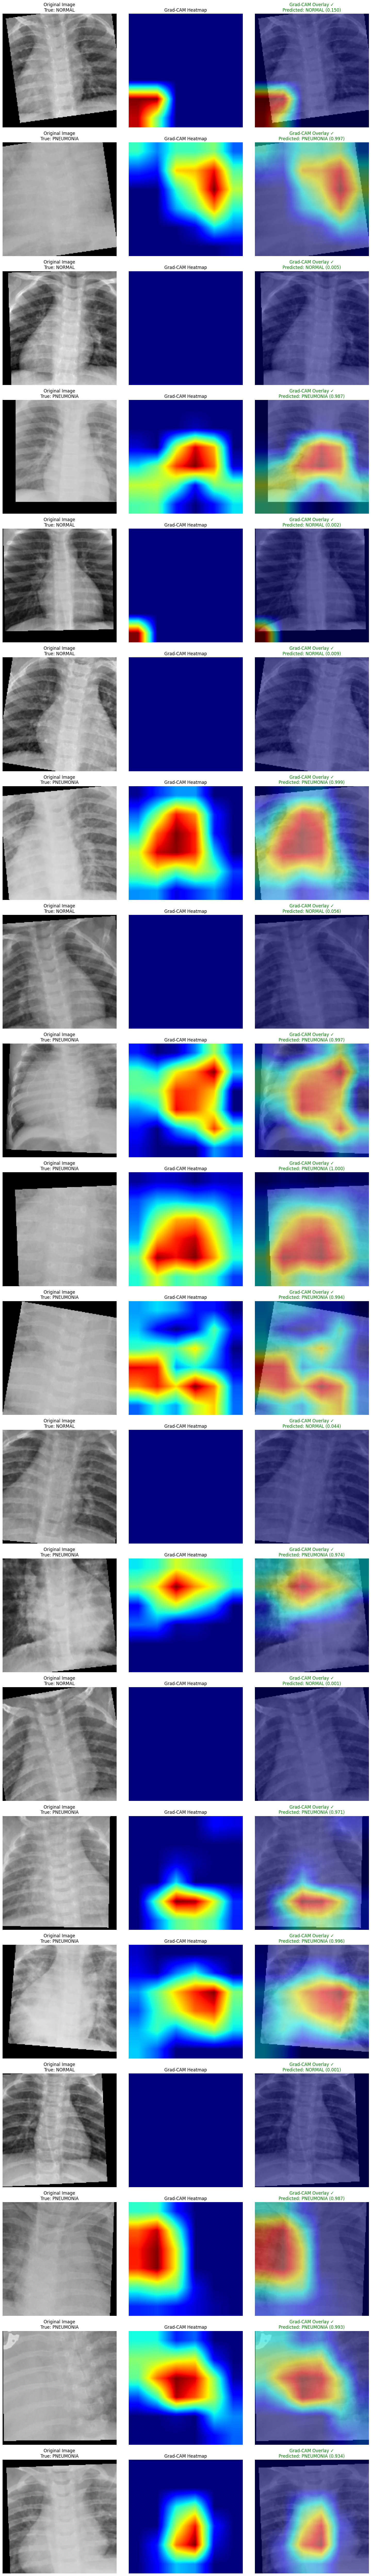

In [ ]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt


class GradCAM:
    def __init__(self, model):
        self.model = model
        self.activations = None
        self.gradients = None

    def generate_heatmap(self, input_image):
        self.model.eval()
        input_image = input_image.requires_grad_(True)

        x = self.model.conv1(input_image)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        x.retain_grad()
        self.activations = x

        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        output = self.model.fc(x)

        self.model.zero_grad()

        score = output[0, 0]
        score.backward()

        self.gradients = self.activations.grad

        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        cam = torch.sum(weights * self.activations, dim=1).squeeze()

        cam = F.relu(cam)

        if cam.max() > cam.min():
            cam = (cam - cam.min()) / (cam.max() - cam.min())

        return cam.detach().cpu().numpy()


def generate_gradcam_for_multiple_images(model, dataloader, num_images=5, device="cpu"):
    model.eval()
    grad_cam = GradCAM(model)

    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))

    for idx in range(min(num_images, len(images))):
        img_tensor = images[idx].unsqueeze(0).to(device)
        true_label = labels[idx].item()

        with torch.no_grad():
            output = model(img_tensor)
            prediction_prob = torch.sigmoid(output).item()
            predicted_label = 1 if prediction_prob > 0.5 else 0

        heatmap = grad_cam.generate_heatmap(img_tensor)

        img = images[idx].permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        img_height, img_width = img.shape[:2]

        heatmap_resized = cv2.resize(heatmap, (img_width, img_height))

        heatmap_colored = np.uint8(255 * heatmap_resized)
        heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        heatmap_colored = heatmap_colored.astype(np.float32) / 255.0

        superimposed_img = heatmap_colored * 0.5 + img * 0.5
        superimposed_img = np.clip(superimposed_img, 0, 1)

        is_correct = "✓" if predicted_label == true_label else "✗"

        axes[idx, 0].imshow(img, cmap='gray')
        axes[idx, 0].set_title(f"Original Image\nTrue: {class_names[true_label]}", fontsize=12)
        axes[idx, 0].axis("off")

        axes[idx, 1].imshow(heatmap_resized, cmap='jet', vmin=0, vmax=1)
        axes[idx, 1].set_title(f"Grad-CAM Heatmap", fontsize=12)
        axes[idx, 1].axis("off")

        axes[idx, 2].imshow(superimposed_img)
        axes[idx, 2].set_title(
            f"Grad-CAM Overlay {is_correct}\n"
            f"Predicted: {class_names[predicted_label]} ({prediction_prob:.3f})",
            fontsize=12,
            color='green' if is_correct == "✓" else 'red'
        )
        axes[idx, 2].axis("off")

        print(f"Image {idx+1}:")
        print(f"  True Label: {class_names[true_label]}")
        print(f"  Predicted: {class_names[predicted_label]} (probability: {prediction_prob:.4f})")
        print(f"  Correct: {is_correct}\n")

    plt.tight_layout()
    plt.show()


print("Generating Grad-CAM visualizations for 5 test images...\n")
generate_gradcam_for_multiple_images(
    model_baseline,
    dataloaders['train'],
    num_images=20,
    device=device
)

In [134]:
# Get a batch of images from the test set
dataiter = iter(dataloaders['test'])
images, labels = next(dataiter)

# Select one image (e.g., the first one in the batch)
idx = 0
img_tensor = images[idx].unsqueeze(0)
label = labels[idx].item()

print(f"True Label: {class_names[label]}")

# Since you used ResNet18, 'layer4' is the best layer for Grad-CAM
show_gradcam(img_tensor, model_baseline, model_baseline.layer4)

True Label: NORMAL


TypeError: cannot create weak reference to 'dict' object